### Imports

In [1]:
# from differentiable_cost import proximity_cost
import torch
import numpy as np
from torch.nn.functional import affine_grid, grid_sample
from scipy.misc import imread
from matplotlib import pyplot as plt

In [2]:
def proximity_cost(images, states, car_size=(6.4, 14.3), green_channel=1, unnormalize=False, s_mean=None, s_std=None):
    SCALE = 0.25
    safe_factor = 1.5
    bsize, npred, nchannels, crop_h, crop_w = images.size(0), images.size(1), images.size(2), images.size(
        3), images.size(4)
    images = images.view(bsize * npred, nchannels, crop_h, crop_w)
    states = states.view(bsize * npred, 4).clone()
    
    if unnormalize:
        states = states * (1e-8 + s_std.view(1, 4).expand(states.size())).cuda()
        states = states + s_mean.view(1, 4).expand(states.size()).cuda()
    speed = states[:, 2:].norm(2, 1) * SCALE  # pixel/s
    width, length = car_size[ 0], car_size[ 1]  # feet
    width = width * SCALE * (0.3048 * 24 / 3.7)  # pixels
    length = length * SCALE * (0.3048 * 24 / 3.7)  # pixels 

    safe_distance = torch.abs(speed) * safe_factor + (1 * 24 / 3.7) * SCALE  # plus one metre (TODO change)

    # Compute x/y minimum distance to other vehicles (pixel version)
    # Account for 1 metre overlap (low data accuracy)
    alpha = 1 * SCALE * (24 / 3.7)  # 1 m overlap collision
    # Create separable proximity mask

    max_x = torch.ceil((crop_h - torch.clamp(torch.tensor([length - alpha]), min=0)) / 2)
    max_y = torch.ceil((crop_w - torch.clamp(torch.tensor([width - alpha]), min=0)) / 2)
    max_x = max_x.view(bsize, 1).expand(bsize, npred).contiguous().view(bsize * npred).cuda()
    max_y = max_y.view(bsize, 1).expand(bsize, npred).contiguous().view(bsize * npred).cuda()


    min_x = torch.clamp(max_x.cpu() - safe_distance, min=0)
    min_y = np.ceil(crop_w / 2 - width)  # assumes other._width / 2 = self._width / 2
    min_y = torch.tensor(min_y)
    min_y = min_y.view(bsize, 1).expand(bsize, npred).contiguous().view(bsize * npred).cuda()

    x_filter = (1 - torch.abs(torch.linspace(-1, 1, crop_h))) * crop_h / 2
    x_filter = x_filter.unsqueeze(0).expand(bsize * npred, crop_h).cuda()
    x_filter = torch.min(x_filter, max_x.view(bsize * npred, 1).expand(x_filter.size()))
    x_filter = torch.max(x_filter.cpu(), min_x.view(bsize * npred, 1).cpu())

    max_x = max_x.cpu()
    x_filter = (x_filter - min_x.view(bsize * npred, 1)) / (max_x - min_x).view(bsize * npred, 1)
    y_filter = (1 - torch.abs(torch.linspace(-1, 1, crop_w))) * crop_w / 2
    y_filter = y_filter.view(1, crop_w).expand(bsize * npred, crop_w).cuda()
    y_filter = torch.min(y_filter, max_y.view(bsize * npred, 1))
    y_filter = torch.max(y_filter, min_y.view(bsize * npred, 1))
    y_filter = (y_filter - min_y.view(bsize * npred, 1)) / (max_y.view(bsize * npred, 1) - min_y.view(bsize * npred, 1))
    x_filter = x_filter.cpu()
    y_filter = y_filter.cpu()
    proximity_mask = torch.bmm(x_filter.view(-1, crop_h, 1), y_filter.view(-1, 1, crop_w))
    proximity_mask = proximity_mask.view(bsize, npred, crop_h, crop_w) * safe_distance
    images = images.view(bsize, npred, nchannels, crop_h, crop_w)
#     ipdb.set_trace()
    costs = torch.max((proximity_mask.cpu() * images[:,:, green_channel].float().cpu()).view(bsize, npred, -1), 2)[0]
    #    costs = torch.sum((proximity_mask * images[:, :, green_channel].float()).view(bsize, npred, -1), 2)
    #    costs = torch.max((proximity_mask * images[:, :, green_channel].float()).view(bsize, npred, -1), 2)[0]
    vertical_diff = proximity_mask[:,:,1:,:] - proximity_mask[:,:,:-1,:]
    horizontal_diff = proximity_mask[:,:,:,1:] - proximity_mask[:,:,:,:-1]
    return costs.cpu(), proximity_mask.cpu(), vertical_diff, horizontal_diff


## Debug functions

These two functions alow us to backpropagate our cost to an affine transformation. We look at the gradient at the identity transformation

In [3]:
def test(image, green_channel, speed=40):
    state = torch.zeros((4))
    state[2] = speed
    state[3] = 0.
    image_var = torch.tensor(image, requires_grad=True)
    trans = torch.tensor([[[.999, 0., 0.], [0., .999, 0.0]]], requires_grad=True)
    grid = affine_grid(trans, torch.Size((1, 3, 117, 24)))
    future_context = grid_sample(image_var[0].float(), grid)
    cost, mask, vertical_diff, horizontal_diff = proximity_cost(future_context.unsqueeze(0)/255., state.unsqueeze(0), green_channel=green_channel)
    future_context.retain_grad()
    grid.retain_grad()
    trans.retain_grad()
    cost.backward(retain_graph=True)
    
    return future_context, mask, trans.grad, vertical_diff, horizontal_diff

In [4]:
def plot_test(image, green_channel=1, speed=40):
    future_context, mask, trans_grad, vertical_diff, horizontal_diff= test(image, green_channel, speed)
    plt.figure(figsize=(15,5))
    plt.subplot(161)
    plt.imshow(mask[0][0])
    plt.subplot(162)
    plt.imshow(image[0][0].permute((1,2,0))/255.)
    plt.subplot(163)
    plt.imshow((mask[0]*future_context.detach()[0]).permute((1,2,0)).numpy().astype(int))
    plt.subplot(164)
    plt.imshow(vertical_diff[0][0])
    plt.subplot(165)
    plt.imshow(horizontal_diff[0][0])
    print(f'vertical diff max: {vertical_diff.max().item():.5}')
    print(f'horizontal diff max: {horizontal_diff.max().item():.5}')
    print(f'mask max: {mask.max().item():.5}')
    print(f'cost (max value): {(mask[0]*future_context.detach()[0]).max().item():.5}')
    return vertical_diff, horizontal_diff

/home/serkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


vertical diff max: 0.83321
horizontal diff max: 13.608
mask max: 32.318
cost (max value): 6794.0


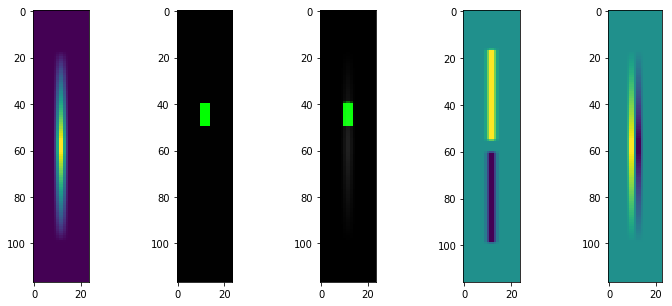

In [5]:
image = torch.ones((1, 1, 3, 117, 24))
image[0, 0, 1, 40:50, 10:14] = 255.
vertical_diff, horizontal_diff = plot_test(image, speed=100)

In [6]:
print(vertical_diff[0,0,30:80,9:15])

tensor([[ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8332,  0.4824,  0.1316],
        [ 0.1316,  0.4824,  0.8332,  0.8

/home/serkan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


vertical diff max: 0.83321
horizontal diff max: 3.8249
mask max: 9.0842
cost (max value): 922.54


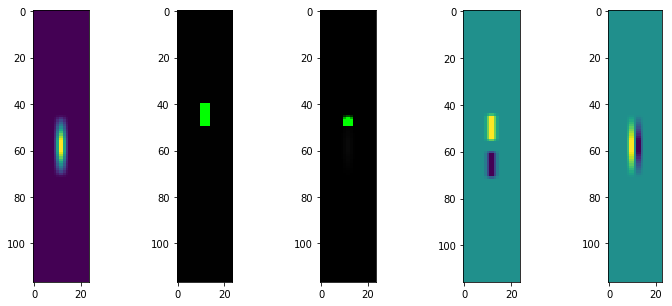

In [7]:
image = torch.ones((1, 1, 3, 117, 24))
image[0, 0, 1, 40:50, 10:14] = 255.
vertical_diff, horizontal_diff = plot_test(image, speed=25)

In [8]:
print(vertical_diff[0,0,30:80,9:15])

tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000],
        [ 0.0502,  0.1839,  0.3177,  0.3177,  0.1839,  0.0502],
        [ 0.1316,  0.4824,  0.8332,  0.8